# dependecies

In [1]:
import json
import csv
import random
import numpy as np
from matplotlib import pyplot as plt, colors as pltcolors, patches
from PIL import Image
import ssdseglib

# global variables / objects

In [2]:
# input image shape
INPUT_IMAGE_SHAPE = (480, 640)

# labels conversions
LABEL_CODE_TO_DESC = {
    1: 'monorail',
    2: 'person',
    3: 'forklift'
}

LABEL_CODE_TO_COLOR = {
    1: 'red',
    2: 'green',
    3: 'blue'
}

# object detection

object detection it's a computer vision task where the goal it's to identify and localize multiple objects within an image or a video frame.

it combines two main challenges:

* **classification**: it's a classification problem, where the task it's to determine the type of objects present in the image

* **localization**: it's a regression problem, where the task it's to determine the location of detected objects within the image, usually providing coordinates for a bounding box around each object

## ground truth data

let's see some ground truth data examples for an object detection task

In [3]:
# read training data
with open('data/train.json', 'r') as f:
    data = json.load(f)

In [ ]:
# plot 5 random samples
for path_image, path_mask, path_labels_boxes in random.sample(data, k=5):

    # read labels and boxes
    with open(path_labels_boxes, 'r') as f:
        labels_boxes = list(csv.reader(f))
    
    # read image
    image = Image.open(path_image)
    image = np.array(image)
    image = image.astype(np.int32)

    # create the plot
    fig = plt.figure(figsize=(8, 6))

    # plot the image
    plt.imshow(image, vmin=0, vmax=255)
    plt.axis('off')

    # get the current plot object
    ax = plt.gca()

    # plot bounding boxes
    for label, xmin, ymin, xmax, ymax in labels_boxes:
        # type conversions
        label = int(label)
        xmin = float(xmin)
        ymin = float(ymin)
        xmax = float(xmax)
        ymax = float(ymax)

        # bounding boxes
        rect = patches.Rectangle((xmin, ymin), xmax - xmin + 1, ymax - ymin + 1, linewidth=1, edgecolor=LABEL_CODE_TO_COLOR[label], facecolor='none')
        ax.add_patch(rect)

        # label descriptions
        plt.text(xmin, ymin, LABEL_CODE_TO_DESC[label], fontsize=8, color=LABEL_CODE_TO_COLOR[label], verticalalignment='top')

    # show the plot
    plt.show()

## ssd - single shot multibox detector

in computer vision there are various approaches to solve object detection problems, one of them it's the single shot multiBox detector (ssd).

ssd is an object detection framework that aims to simultaneously predict object classes and bounding box locations in a single pass.

### default grids

the basic idea of ssd it's fairly simple: let's imagine to divide an input image into a grid multiple times, each time using a complete different grid!

why not only one? don't worry, i'll explain it very soon :smiley:

In [5]:
# create default bounding boxes
default_bounding_boxes = ssdseglib.boxes.DefaultBoundingBoxes(
    feature_maps_shapes=((30, 40), (15, 20), (8, 10), (4, 5)),
    centers_padding_from_borders_percentage=0.025,
    boxes_scales=(0.2, 0.9),
    additional_square_box=True,  
)

# scale default bounding boxes to image shape
default_bounding_boxes.rescale_boxes_coordinates(image_shape=INPUT_IMAGE_SHAPE)

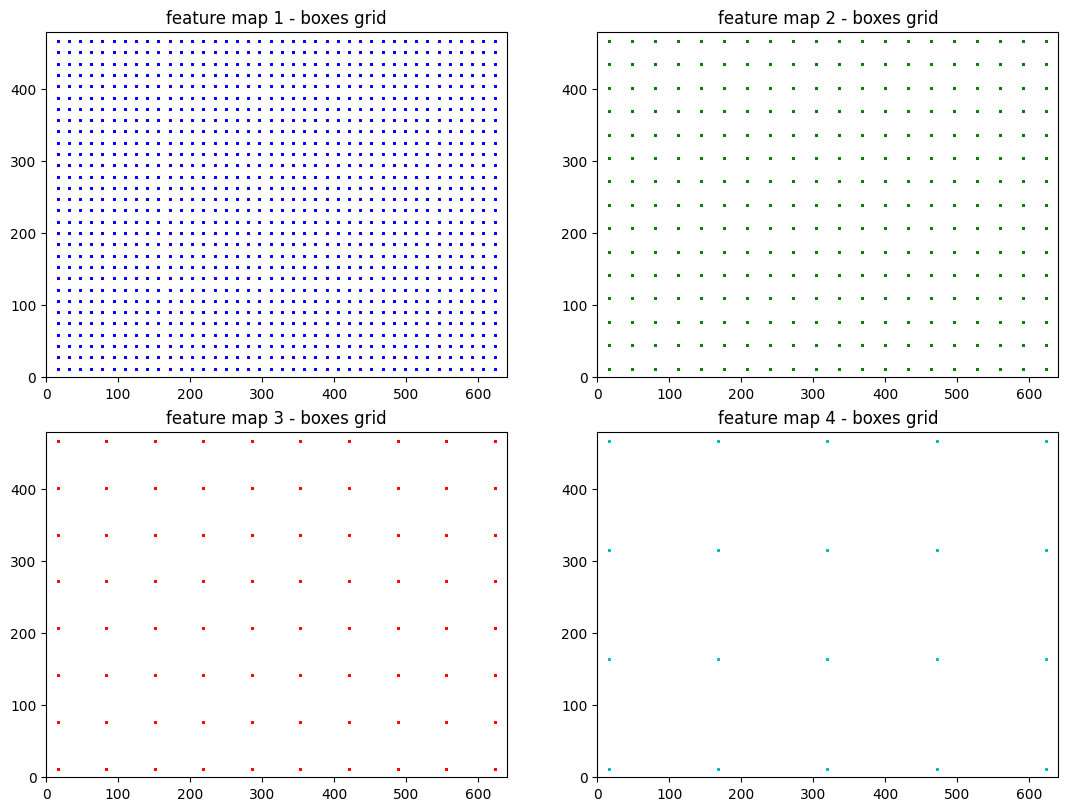

In [6]:
# create subplots and set figure size
fig_size_width = 11
fig, axes = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
fig.set_size_inches(fig_size_width, int(fig_size_width / (INPUT_IMAGE_SHAPE[1] / INPUT_IMAGE_SHAPE[0])))

# set aspect ratio for each subplot
for ax in axes.flat:
    ax.set_aspect('equal')
axes = axes.flatten()

# pick a different color for each grid
colors = list(pltcolors.BASE_COLORS.values())[:len(default_bounding_boxes.feature_maps_shapes)]

# get boxes centroids coordinates for each feature map and plot the boxes centers
i = 0
for boxes_default, color in zip(default_bounding_boxes.get_boxes_coordinates_centroids('feature-maps'), colors):

    # reshape
    boxes_default = boxes_default.reshape((-1, boxes_default.shape[-1]))

    # set plot axes limits and title
    axes[i].set_xlim(0, INPUT_IMAGE_SHAPE[1])
    axes[i].set_ylim(0, INPUT_IMAGE_SHAPE[0])
    axes[i].set_title(f'feature map {i +1} - boxes grid')

    # plot centers
    axes[i].scatter(x=boxes_default[:, 0], y=boxes_default[:, 1], color=color, marker='o', s=1)
    
    i+=1

# show the plot
plt.show()

### default bounding boxes

before explaining why multiple grids, let's keep focusing on the basic idea behind ssd.

rembember that we just divided the input image into different grids.

now try to think about a set of N boxes (or rectangles if you prefer), each one slightly different, with different aspect ratios, weigths, heights...

let's imagine to place this set of boxes on each point of the grids, so that boxes centers corresponds to grids points.

this is exactly the concept of default bounding boxes proposed by ssd.

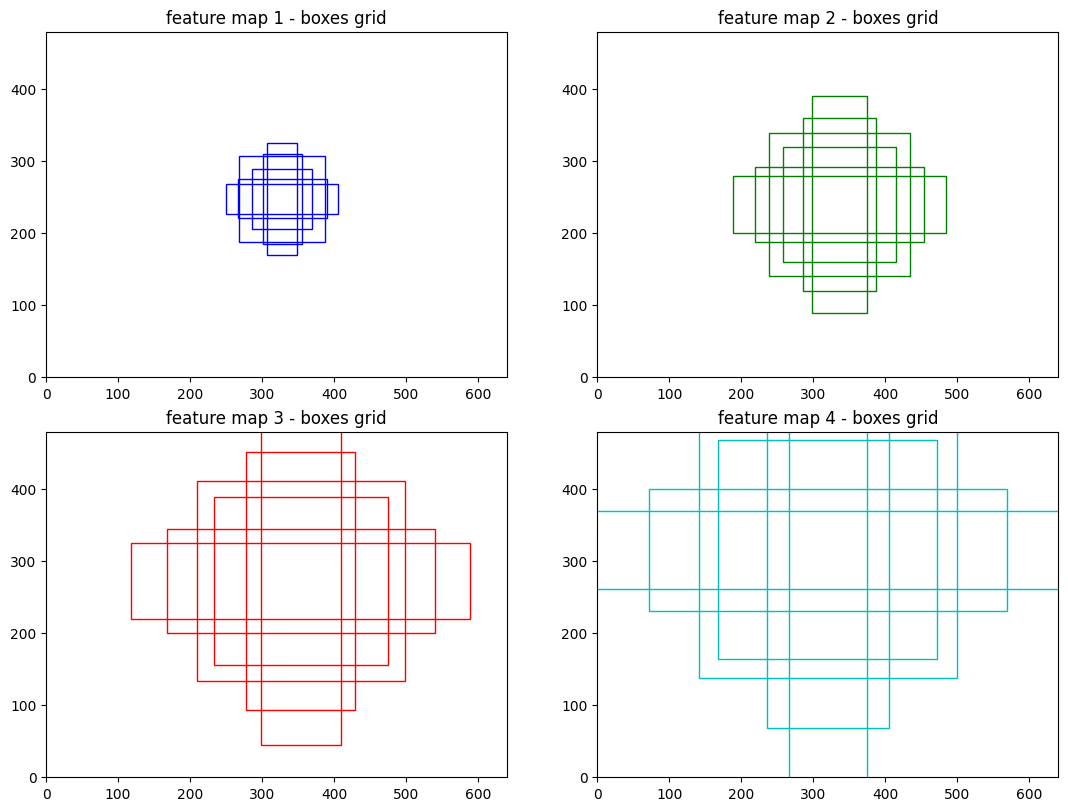

In [7]:
# create subplots and set figure size
fig_size_width = 11
fig, axes = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
fig.set_size_inches(fig_size_width, int(fig_size_width / (INPUT_IMAGE_SHAPE[1] / INPUT_IMAGE_SHAPE[0])))

# set aspect ratio for each subplot
for ax in axes.flat:
    ax.set_aspect('equal')
axes = axes.flatten()

# pick a different color for each grid
colors = list(pltcolors.BASE_COLORS.values())[:len(default_bounding_boxes.feature_maps_shapes)]

# get boxes corners coordinates for each feature map and plot the boxes
i = 0
for boxes_default, color in zip(default_bounding_boxes.get_boxes_coordinates_corners('feature-maps'), colors):
   
    # extract boxes around the center of the feature map
    feat_map_center_x = boxes_default.shape[1] // 2
    feat_map_center_y = boxes_default.shape[0] // 2
    boxes_default = boxes_default[feat_map_center_y, feat_map_center_x, :, :]

    # set plot axes limits and title
    axes[i].set_xlim(0, INPUT_IMAGE_SHAPE[1])
    axes[i].set_ylim(0, INPUT_IMAGE_SHAPE[0])
    axes[i].set_title(f'feature map {i +1} - boxes grid')

    # plot boxes
    for xmin, ymin, xmax, ymax in boxes_default:
        axes[i].add_patch(patches.Rectangle((xmin, ymin), xmax - xmin + 1, ymax - ymin + 1, linewidth=1, edgecolor=color, facecolor='none'))
                
    i+=1

# show the plot
plt.show()

### sum it up

ssd framework for object detection propose to divide the input image with K different grids and to place on each grids point a set of N boxes.

this operation will create a set of default bounding boxes, often called also anchor boxes.

they are useful because ideally a neural network can leverage on this set of pre-defined boxes instead of figuring out from scratch where the objects are in the image.

basically ssd propose to train a neural network so that:

* it will predict what type of object it's inside each default bounding box
* it will predict how far a default bounding box it's from the real bounding box

to achieve that, we need to encode properly the ground truth data, a process that consists in calculating the distance/offsets between the default bounding boxes and a ground truth box.